In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
mp_key = "kqoGOG3L85VvUgz1hujhLArYSrmj87fq"
mp_id = "mp-10182"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
temps = np.arange(0,1000,5)
R = 8.314
Nat = len(prim_struc)
ph_cv = np.array([ph_dos.cv(temps[i]) for i in range(len(temps))])/(3*Nat*R)

# Courbe de la chaleur spécifique

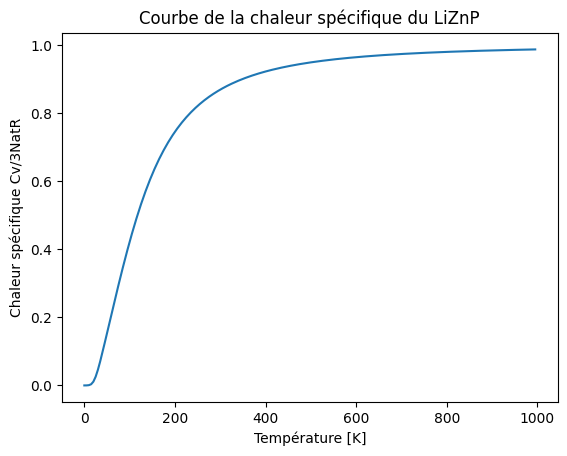

In [5]:
plt.plot(temps, ph_cv)
plt.title('Courbe de la chaleur spécifique du LiZnP')
plt.xlabel('Température [K]')
plt.ylabel('Chaleur spécifique Cv/3NatR')
plt.show()

# Modèle d'Einstein

Température d'Einstein = 352 K


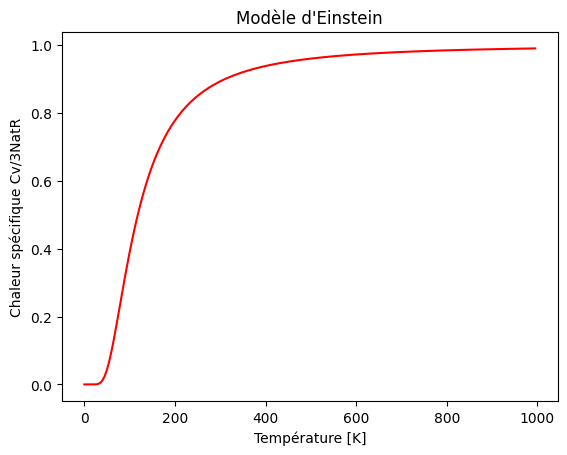

In [6]:
def einstein(e, T):
    cv_pred = ((e/T)**2)*np.exp(e/T) / ((np.exp(e/T)-1)**2)
    return cv_pred

erreur_min_e = 0
t_opt_e = 1
for i in range(1,1000):
    erreur = 0
    for j in range(1,200):
        cv_pred = einstein(i, temps[j])
        a = (cv_pred-ph_cv[j])**2
        erreur += a
    if i==1:
        erreur_min_e = erreur
    if erreur < erreur_min_e:
        erreur_min_e = erreur
        t_opt_e = i
print("Température d'Einstein =",t_opt_e,"K")

cv_einstein =[temps[0]]
for i in range(1,200):
    cv_einstein.append(einstein(t_opt_e, temps[i]))

plt.plot(temps, cv_einstein, color='red')
plt.title("Modèle d'Einstein")
plt.xlabel('Température [K]')
plt.ylabel('Chaleur spécifique Cv/3NatR')
plt.show()

# Modèle de Debye

Température de Debye = 476 K


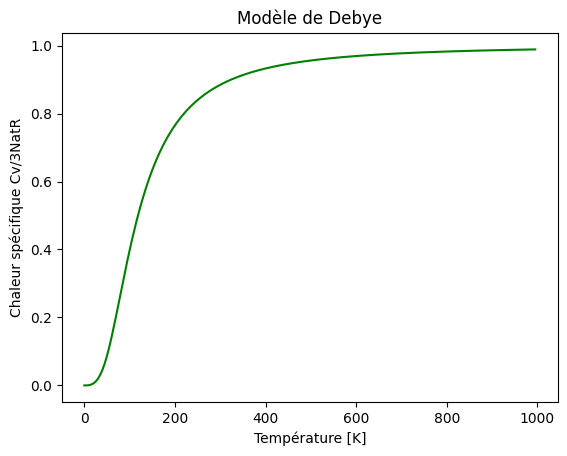

In [7]:
def f(x):
    return (x**4)*np.exp(x) / ((np.exp(x)-1)**2)

def debye(d, T):
    cv_pred = 3*((T/d)**3)*integrate.quad(f, 0, d/T)[0]
    return cv_pred

erreur_min_d = 0
t_opt_d = 1
for i in range(1,1000):
    erreur = 0
    for j in range(1,200):
        cv_pred = debye(i, temps[j])
        a = (cv_pred-ph_cv[j])**2
        erreur += a
    if i==1:
        erreur_min_d = erreur
    if erreur < erreur_min_d:
        erreur_min_d = erreur
        t_opt_d = i
print("Température de Debye =",t_opt_d,"K")

cv_debye=[temps[0]]
for i in range(1,200):
    cv_debye.append(debye(t_opt_d, temps[i]))

plt.plot(temps, cv_debye, color="green")
plt.title("Modèle de Debye")
plt.xlabel('Température [K]')
plt.ylabel('Chaleur spécifique Cv/3NatR')
plt.show()

# Comparaison des 3 courbes

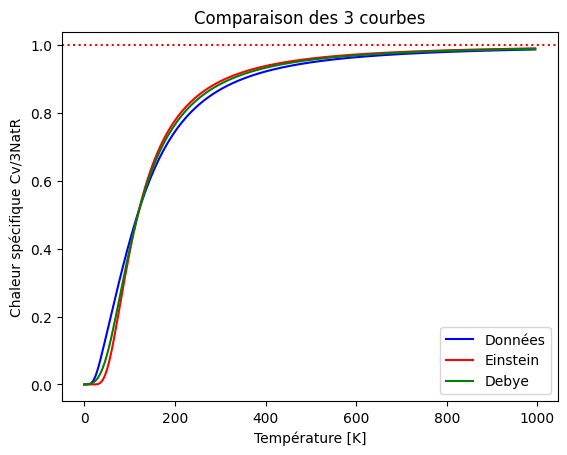

In [8]:
plt.plot(temps, ph_cv, label='Données', color='blue')
plt.plot(temps, cv_einstein, label="Einstein", color='red')
plt.plot(temps, cv_debye, label="Debye", color="green")
plt.axhline(y=1, color='red', linestyle= 'dotted')
plt.title('Comparaison des 3 courbes')
plt.xlabel('Température [K]')
plt.ylabel('Chaleur spécifique Cv/3NatR')
plt.legend()
plt.show()

# Les 3 densités d'états de phonons

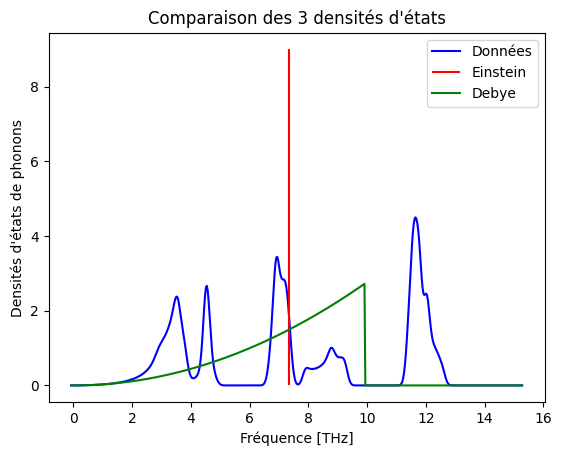

In [9]:
k_B = 1.380649e-23
conv_THz = 1e-12
h_barre = 1.055e-34

freq = ph_dos.frequencies 
dens = ph_dos.densities

omega_e = conv_THz*k_B*t_opt_e/h_barre
f_e = omega_e/(2*np.pi)

omega_d = conv_THz*k_B*t_opt_d /h_barre

dens_d = np.zeros(len(freq))
for i,f in enumerate(freq):
    omega = 2*np.pi*f
    if omega < omega_d:
        dens_d[i] = (9*Nat*(omega)**2/(omega_d**3))

plt.plot(freq, dens,color="blue", label="Données")
plt.vlines(f_e, 0, 3 * Nat ,color="red", label = "Einstein")
plt.plot(freq, dens_d*(2*np.pi), color='green', label="Debye")
plt.title("Comparaison des 3 densités d'états")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence [THz]")
plt.legend()
plt.show()